<a href="https://colab.research.google.com/github/taavip/automatic-control-of-electrical-equipment-basis-of-price/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

#-----------------------


from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.model_selection import *

##

In [2]:
def get_1y_tabel(now):
  url = ('https://dashboard.elering.ee/api/nps/price?start='+str((now + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%Y-%m-%d %H:%M"))+'&end='+str((now + timedelta(hours=36)).date().strftime("%Y-%m-%d %H:%M")))

  response = requests.get(url).json()

  ep=pd.json_normalize(response['data']['ee'])
  ep['datetime'] = pd.to_datetime(ep['timestamp'], unit='s')
  ep.datetime = ep.datetime.dt.tz_localize('UTC').dt.tz_convert('Europe/Tallinn')
  ep['dow'] = pd.to_datetime(ep['timestamp'], unit='s').dt.dayofweek
  ep['hour'] = pd.to_datetime(ep['timestamp'], unit='s').dt.hour
  ep['week'] = pd.to_datetime(ep['timestamp'], unit='s').dt.isocalendar().week

 # url=("http://ohuseire.ee/station/csv?filter%5BstationId%5D=36&filter%5BdateFrom%5D="+str((now + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%d.%m.%Y"))+"&filter%5BdateUntil%5D="+str((now ).date().strftime("%d.%m.%Y")))

#  s=requests.get(url).content
#  c=pd.read_csv(io.StringIO(s.decode('utf-8')), sep=';' )

#  c['timestamp'] = (pd.to_datetime(c["Kuupäev"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
#  d = c[["WD10",'timestamp']]
#  c = c.stack().str.replace(',','.').unstack()
#  c["NO2"] = pd.to_numeric(c["NO2"], errors='coerce')
#  c["CO"] = pd.to_numeric(c["CO"], errors='coerce')
#  c["PM10"] = pd.to_numeric(c["PM10"], errors='coerce')
#  c["HUM"] = pd.to_numeric(c["HUM"], errors='coerce')
#  c["PM2.5"] = pd.to_numeric(c["PM2.5"], errors='coerce')
#  c["TEMP"] = pd.to_numeric(c["TEMP"], errors='coerce')
#  c["WS10"] = pd.to_numeric(c["WS10"], errors='coerce')
#  c["WD10"] = d["WD10"]
#  c['timestamp'] = d['timestamp']
#  c= c.drop("Kuupäev",axis=1)

  #pd.merge(c, ep, on=['timestamp'])
  return ep


In [3]:
def get_tabel(y):
  rdf = get_1y_tabel(datetime.now())
  for year in range(1,y):
    print(datetime.now()-relativedelta(years=year))
    temp_df = get_1y_tabel(datetime.now()-relativedelta(years=year))
    rdf = pd.concat([rdf, temp_df])
  return rdf.sort_values(by=['datetime'],ignore_index=True)


In [4]:
df = get_tabel(8)


2020-01-04 20:17:41.542871
2019-01-04 20:17:43.060676
2018-01-04 20:17:44.624495
2017-01-04 20:17:46.580626
2016-01-04 20:17:48.071553
2015-01-04 20:17:49.607516
2014-01-04 20:17:51.311122


In [5]:
y=2
datetime.now()-relativedelta(years=y)

datetime.datetime(2019, 1, 4, 20, 17, 52, 758130)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63532 entries, 0 to 63531
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype                         
---  ------     --------------  -----                         
 0   timestamp  63532 non-null  int64                         
 1   price      63532 non-null  float64                       
 2   datetime   63532 non-null  datetime64[ns, Europe/Tallinn]
 3   dow        63532 non-null  int64                         
 4   hour       63532 non-null  int64                         
 5   week       63532 non-null  UInt32                        
dtypes: UInt32(1), datetime64[ns, Europe/Tallinn](1), float64(1), int64(3)
memory usage: 2.7 MB


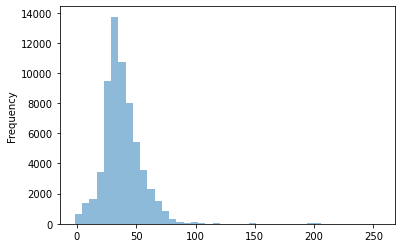

In [7]:
df.price.plot.hist(bins=42, alpha=0.5)

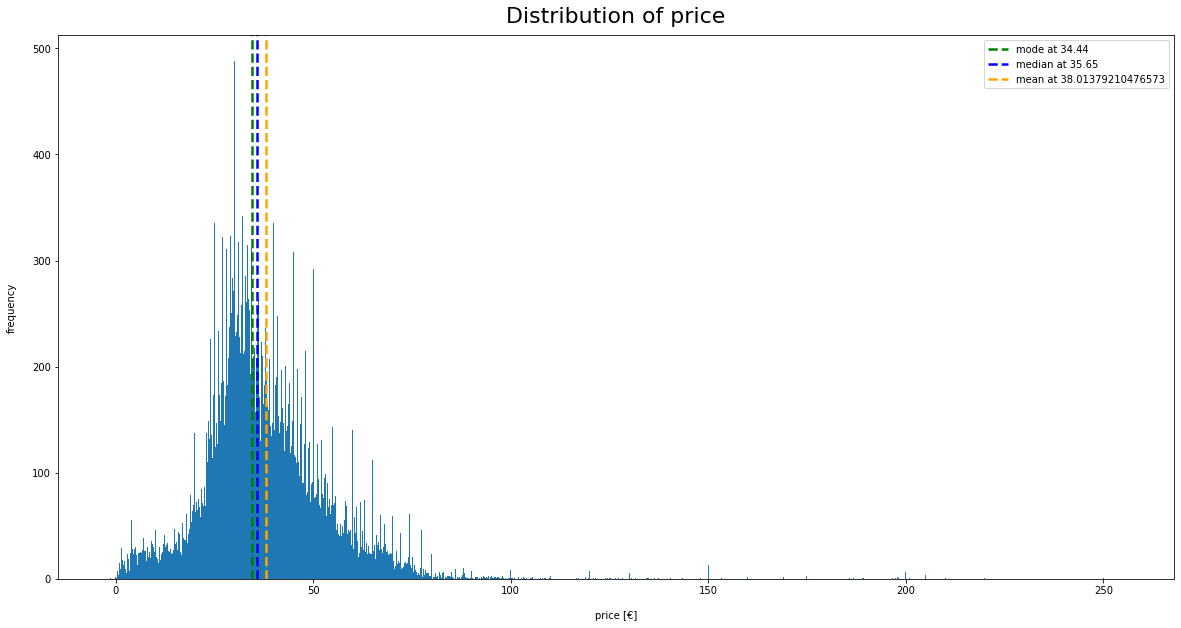

In [8]:
#df['price'].plot(kind='hist', figsize=(10, 8), linewidth=2, color='whitesmoke', edgecolor='gray')
plt.figure(figsize=(20,10))
plt.hist(df['price'], bins=2250 )

plt.xlabel("price [€]", labelpad=15)
plt.ylabel("frequency", labelpad=15)
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of price", y=1.012, fontsize=22)
measurements = [df['price'].mode()[0], df['price'].median(), df['price'].mean()]
names = ["mode", "median", "mean"]
colors = ['green', 'blue', 'orange']
for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
plt.legend();

In [9]:
def nsmall(a, n):
    return np.partition(a, n)[n]

In [10]:
def best_time(df, min, per):
  field=["on_off_"+str(min)+"_"+str(per)]

  df[field] = df.price <= df.price.rolling(window=per,min_periods=per,center=True).apply(lambda x: nsmall(x, min-1))

  #print 
  plot_n(75,field,df)


  return df

In [11]:
def plot_n(n,field,df):
    #print 
  a =df.loc[:,['price','datetime']+field][-n:]
  plt.figure(figsize=(20,10))
  plt.plot(pd.to_datetime(a.datetime), a.price,  marker='x', mec = 'r', markersize=12, markevery=(~a[field]).iloc[:, 0].tolist())
  plt.plot(pd.to_datetime(a.datetime), a.price, linestyle="None", marker='o', c='g', markersize=12, markevery=a[field].iloc[:, 0].tolist())
  plt.grid(b=None, which='major', axis='both')
  plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')
  plt.axhline(df['price'].median(), color = 'r', linestyle = '-') 
  
  # rendering the plot 
  plt.show()

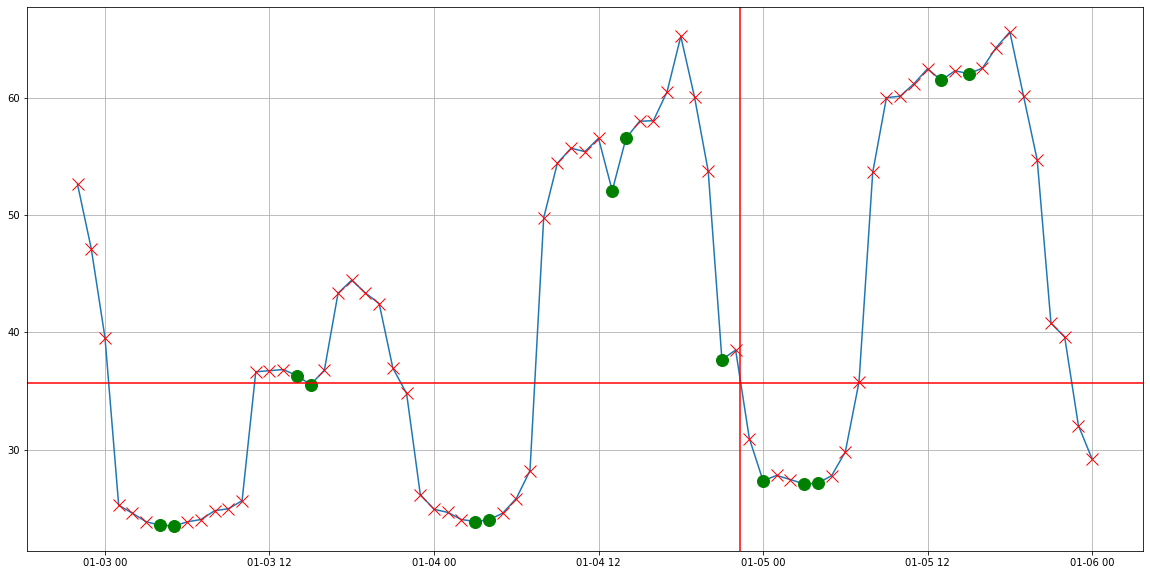

In [12]:
df = best_time(df,2, 5)
#df.tail(50)

In [13]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true+abs(y_true.min()), y_pred+abs(y_true.min()))
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [14]:
data = df.copy()
# creating new dataframe from consumption column
data_consumption = df.copy()
# inserting new column with yesterday's consumption values
#data_consumption.loc[:,'1h'] = data_consumption.loc[:,'price'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
#data_consumption.loc[:,'1h_Diff'] = data_consumption.loc[:,'1h'].diff()

data_consumption['avg24h'] = data_consumption.price.rolling(window=24,min_periods=1).mean()
# dropping NAs
data_consumption = data_consumption.dropna()


In [15]:
num = int(len(data_consumption[:])*0.8)
print(num)
X_train = data_consumption[:num].drop(['price', 'datetime'], axis = 1)
y_train = data_consumption.price[:num]
X_test = data_consumption[num:].drop(['price','datetime'], axis = 1)
y_test = data_consumption.price[num:]

50825


LR: 0.290209 (0.046289)
NN: -0.263570 (0.263350)
KNN: -0.357016 (0.400216)
RF: 0.350785 (0.161809)
SVR: -0.372217 (0.795817)


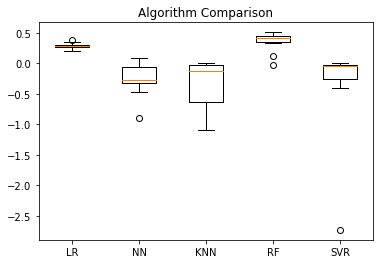

In [16]:


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


model = RandomForestRegressor()
param_search = { 
    'n_estimators': [ 100,50 ,20, 10, 5 ],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [i for i in range(9,11)]
}
tscv = TimeSeriesSplit(n_splits=24)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [27]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.5365
mean_squared_log_error:  0.2212
r2:  0.5182
MAE:  9.2784
MSE:  202.0172
RMSE:  14.2133


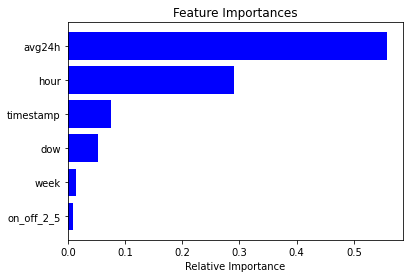

In [28]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

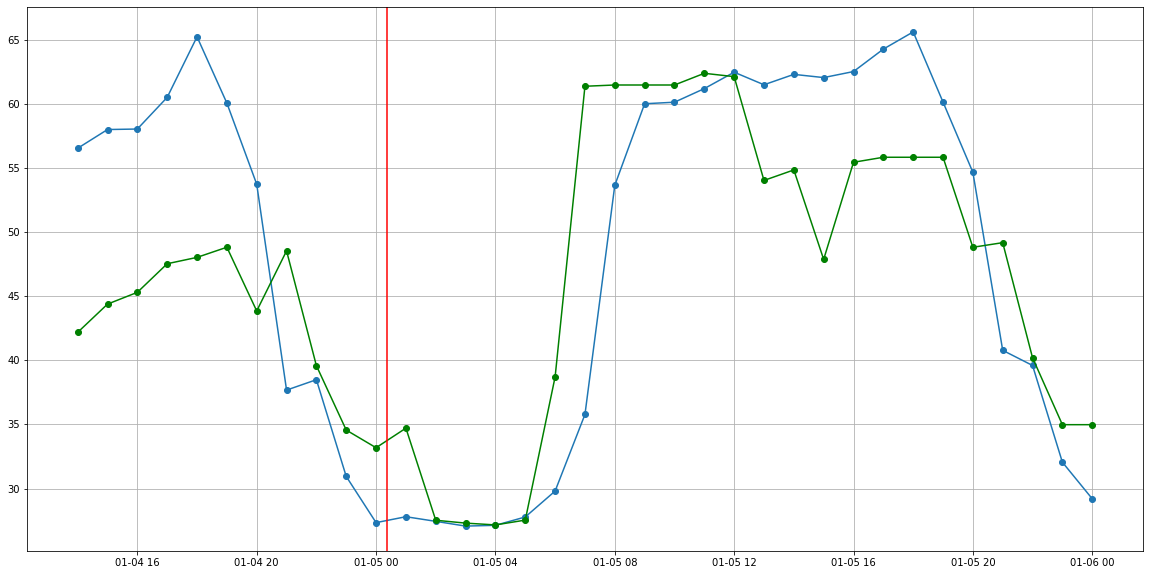

In [29]:
a =df.loc[:,['price','datetime']][-35:]

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(a.datetime), a.price,  marker='o')
plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s'), best_model.predict(X_test)[-35:],  marker='o',color='green')
#plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:]-a.price,  marker='x',color='cyan')
plt.grid(b=None, which='major', axis='both')
plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')

In [30]:
best_model.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}